In [15]:
import glob
import torch
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
from dalle_pytorch.vae import OpenAIDiscreteVAE
from dalle_pytorch.vae import map_pixels, unmap_pixels
import torch.nn.functional as F
from dalle_pytorch import OpenAIDVAE

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


target_image_size = 112

# ddvae = OpenAIDiscreteVAE('dalle_dvae')
# model = OpenAIDiscreteVAE()
model = OpenAIDVAE('dalle_dvae')

In [29]:
model.vae.dec.blocks.group_1.block_1.res_path.conv_1.w.dtype

torch.float32

In [3]:
model.modules

<bound method Module.modules of OpenAIDiscreteVAE(
  (enc): Encoder(
    (blocks): Sequential(
      (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
      (group_1): Sequential(
        (block_1): EncoderBlock(
          (id_path): Identity()
          (res_path): Sequential(
            (relu_1): ReLU()
            (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_2): ReLU()
            (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_3): ReLU()
            (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_4): ReLU()
            (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          )
        )
        (block_2): EncoderBlock(
          (

In [19]:
model.enc

Encoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): EncoderBlock(
        (id_path): Identity()
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): EncoderBlock(
        (id_path): Identity()
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_

In [8]:
from torch import nn, einsum
from collections import OrderedDict

class EncoderBlock(nn.Module):
    def __init__(self, id_path_is_identity, res_in, hid_dim, res_out):
        super().__init__()
        if id_path_is_identity:
            self.id_path = nn.Identity()
        else:
            self.id_path = nn.Conv2d(res_in, res_out, 1)
        
        self.res_path = nn.Sequential(
            OrderedDict([
                ('relu_1', nn.ReLU()),
                ('conv_1', nn.Conv2d(res_in, hid_dim, 3, padding=(3-1)//2)),
                ('relu_2', nn.ReLU()),
                ('conv_2', nn.Conv2d(hid_dim, hid_dim, 3, padding=(3-1)//2)),
                ('relu_3', nn.ReLU()),
                ('conv_3', nn.Conv2d(hid_dim, hid_dim, 3, padding=(3-1)//2)),
                ('relu_4', nn.ReLU()),
                ('conv_4', nn.Conv2d(hid_dim, res_out, 1))
            ])
        )
    
    def forward(self, x):
        return self.res_path(x) + self.id_path(x)


In [9]:
class Encoder(nn.Module):
    def __init__(self, num_group=4, num_num_tokens=8192, hidden_dim=64, codebook_dim=2048):
        super().__init__()
        self.blocks = nn.Sequential(
            OrderedDict([
                ('input', nn.Conv2d(3, 256, 7, padding=(7-1)//2)),
                ('group_1', nn.Sequential(
                    OrderedDict([
                        ('block_1', EncoderBlock(True, 256, 64, 256)),
                        # ('block_2', EncoderBlock(True, 256, 64, 256)),
                        ('pool', nn.MaxPool2d(2, 2, 0, 1))
                    ])
                )),
                ('group_2', nn.Sequential(
                    OrderedDict([
                        ('block_1', EncoderBlock(False, 256, 128, 512)),
                        # ('block_2', EncoderBlock(True, 512, 128, 512)),
                        ('pool', nn.MaxPool2d(2, 2, 0, 1))
                    ])
                )),
                ('group_3', nn.Sequential(
                    OrderedDict([
                        ('block_1', EncoderBlock(False, 512, 256, 1024)),
                        # ('block_2', EncoderBlock(True, 1024, 256, 1024)),
                        ('pool', nn.MaxPool2d(2, 2, 0, 1))
                    ])
                )),
                # ('group_4', nn.Sequential(
                #     OrderedDict([
                #         ('block_1', EncoderBlock(False, 1024, 512, 2048)),
                #         ('block_2', EncoderBlock(True, 2048, 512, 2048)),
                #     ])
                # )),
                ('output', nn.Sequential(
                    OrderedDict([
                        ('relu', nn.ReLU()),
                        ('conv', nn.Conv2d(1024, 8192, 1))
                    ])
                ))
            ])
        )
    
    def forward(self, x):
        return self.blocks(x)

In [10]:
ii = torch.rand(1,3,112,112)

aa = Encoder()

aa(ii).shape

torch.Size([1, 8192, 14, 14])

In [11]:
import torch.nn.functional as F

F.gumbel_softmax(aa(ii), dim=1)

NameError: name 'aa' is not defined

In [ ]:
imgs = glob.glob('/dalle/sample_images/*')

for image_path in imgs:

    image = Image.open(image_path).convert('RGB')
    img_tens = preprocess(image)

    # display(T.ToPILImage(mode='RGB')(img_tens[0]))
    res_img = Image.fromarray((img_tens[0].permute(1,2,0)*255).numpy().astype(np.uint8)).show()
    res_img.show()
    res_img.save(image_path.split('.png')[0]+'_resiz.png')
    
    a = model.get_codebook_indices(img_tens)
    print(a.shape)
    b = model.decode(a)


    to_pil = T.ToPILImage()
    out_img = to_pil((b[0]*255).type(torch.uint8))
    out_img.show()
    out_img.save(image_path.split('.png')[0]+'_recon.png')
    

In [4]:
img = Image.open('/dalle/sample_images/cat.png').convert('RGB')
print(T.ToTensor()(img))
print(map_pixels(T.ToTensor()(img)))
img_tens = preprocess(img)
print(img_tens)

tensor([[[0.5490, 0.5647, 0.5725,  ..., 0.3686, 0.4196, 0.4000],
         [0.5412, 0.5569, 0.5451,  ..., 0.4039, 0.4510, 0.3765],
         [0.5294, 0.5882, 0.5569,  ..., 0.4039, 0.4235, 0.3647],
         ...,
         [0.9294, 0.8824, 0.9255,  ..., 0.6706, 0.7098, 0.5765],
         [0.9020, 0.8863, 0.9333,  ..., 0.4471, 0.4039, 0.3490],
         [0.9333, 0.9647, 0.9333,  ..., 0.2902, 0.2902, 0.2863]],

        [[0.0980, 0.0980, 0.0941,  ..., 0.0627, 0.0510, 0.0392],
         [0.0863, 0.1020, 0.0784,  ..., 0.0431, 0.0667, 0.0510],
         [0.0863, 0.1294, 0.0902,  ..., 0.0314, 0.0745, 0.0392],
         ...,
         [0.3922, 0.3294, 0.3765,  ..., 0.1843, 0.2431, 0.1098],
         [0.3294, 0.3137, 0.3882,  ..., 0.0941, 0.0196, 0.0353],
         [0.3922, 0.4275, 0.3765,  ..., 0.0510, 0.0980, 0.0667]],

        [[0.2196, 0.2627, 0.2863,  ..., 0.1490, 0.1529, 0.1294],
         [0.2235, 0.1922, 0.1882,  ..., 0.1412, 0.1647, 0.1216],
         [0.1647, 0.2314, 0.2078,  ..., 0.1255, 0.1529, 0.

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:416: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [30]:
from einops import rearrange
from math import sqrt, log
a = model.get_codebook_indices(img_tens)
print(a)
b = model.decode(a)
print(b)
b, n = a.shape
img_seq = rearrange(a, 'b (h w) -> b h w', h = int(sqrt(n)))

z = F.one_hot(img_seq, num_classes = 8192)
z = rearrange(z, 'b h w c -> b c h w').float()
x_stats = model.dec(z)
from dall_e.utils import unmap_pixels
print(x_stats[:, :3].shape)
print(unmap_pixels(torch.sigmoid(x_stats)))

tensor([[2716, 7864, 7864,  ...,  401,  401, 2716]])
tensor([[[[0.5009, 0.5009, 0.5009,  ..., 0.4973, 0.4973, 0.4973],
          [0.5009, 0.5009, 0.5009,  ..., 0.4973, 0.4973, 0.4973],
          [0.5009, 0.5009, 0.5009,  ..., 0.4973, 0.4973, 0.4973],
          ...,
          [0.5009, 0.5009, 0.5009,  ..., 0.5009, 0.5009, 0.5009],
          [0.5009, 0.5009, 0.5009,  ..., 0.5009, 0.5009, 0.5009],
          [0.5009, 0.5009, 0.5009,  ..., 0.5009, 0.5009, 0.5009]],

         [[0.5051, 0.5051, 0.5051,  ..., 0.5047, 0.5047, 0.5047],
          [0.5051, 0.5051, 0.5051,  ..., 0.5047, 0.5047, 0.5047],
          [0.5051, 0.5051, 0.5051,  ..., 0.5047, 0.5047, 0.5047],
          ...,
          [0.5051, 0.5051, 0.5051,  ..., 0.5050, 0.5050, 0.5050],
          [0.5051, 0.5051, 0.5051,  ..., 0.5050, 0.5050, 0.5050],
          [0.5051, 0.5051, 0.5051,  ..., 0.5050, 0.5050, 0.5050]],

         [[0.4992, 0.4992, 0.4992,  ..., 0.5034, 0.5034, 0.5034],
          [0.4993, 0.4993, 0.4993,  ..., 0.5034, 0.5034

In [15]:
from dalle_pytorch import OpenAIDVAE

model = OpenAIDVAE().float()

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:416: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


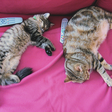

In [3]:
img = Image.open('/dalle/sample_images/cat.png').convert('RGB')
img_tens = preprocess(img)
img_tens

res_img = Image.fromarray((img_tens[0].permute(1,2,0)*255).numpy().astype(np.uint8))
res_img.show()

torch.Size([1, 196])


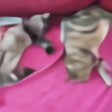

In [5]:
a = model.get_codebook_indices(img_tens)
print(a.shape)
b = model.decode(a)


to_pil = T.ToPILImage()
out_img = to_pil((b[0]*255).type(torch.uint8))
out_img.show()

In [10]:
sum(img_tens-b)

tensor([[[-5.4804e-03, -9.3651e-03,  6.2517e-03,  ..., -6.9877e-02,
          -5.2374e-02, -2.4214e-02],
         [-3.6185e-03, -7.2271e-04,  9.9069e-03,  ..., -6.4139e-02,
          -6.1431e-02, -4.0542e-02],
         [ 2.0698e-02,  7.0806e-03,  1.1552e-02,  ..., -4.9002e-02,
          -5.5496e-02, -6.5941e-02],
         ...,
         [-9.4764e-03, -6.6215e-03, -1.0252e-02,  ...,  6.5138e-03,
           8.4488e-03,  1.9097e-02],
         [-1.6901e-02, -1.4109e-02, -1.5353e-02,  ...,  1.2624e-04,
           1.2895e-02,  6.3170e-03],
         [ 4.1443e-03, -1.1655e-02, -9.2916e-03,  ..., -9.1712e-03,
           9.7411e-03,  2.5281e-02]],

        [[-4.4266e-02, -3.7841e-02, -2.9874e-02,  ..., -6.6088e-03,
          -4.7289e-03, -2.0933e-02],
         [-2.2719e-02, -3.1462e-02, -2.1370e-02,  ..., -8.4886e-03,
          -9.8222e-03, -4.4073e-03],
         [-1.6593e-02, -1.9454e-02, -2.0216e-02,  ..., -4.4370e-03,
          -1.3675e-02, -1.0355e-02],
         ...,
         [ 4.2232e-02,  5

In [29]:
img_tens.dtype == torch.float32

True

In [19]:
3000000*512/42000000

36.57142857142857

In [22]:
import math

-math.log(1e-10)/(19000000*70/32*0.05)

1.1080108718166836e-05

In [18]:
from torch import nn, einsum
from einops import rearrange


loss_fn = F.smooth_l1_loss#F.mse_loss

logits = model.vae.enc(map_pixels(img_tens))
one_hot = F.gumbel_softmax(logits, dim=1)
sampled = model.vae.dec.blocks.input(one_hot)
out = model.vae.dec.blocks.group_1(sampled)
out = model.vae.dec.blocks.group_2(out)
out = model.vae.dec.blocks.group_3(out)
out = model.vae.dec.blocks.group_4(out)
out = model.vae.dec.blocks.output(out)

recon_loss = loss_fn(img_tens, unmap_pixels(torch.sigmoid(out[:, :3])))
print(recon_loss)

logits = rearrange(logits, 'b n h w -> b (h w) n')
log_qy = F.log_softmax(logits, dim = -1)
print(log_qy)
log_uniform = torch.log(torch.tensor([1. / 8192]))
print(log_uniform)
kl_div = F.kl_div(log_uniform, log_qy, None, None, 'batchmean', log_target = True)
print(kl_div)
loss = recon_loss + (kl_div * 6.6)
loss


tensor(0.0024, grad_fn=<SmoothL1LossBackward0>)
tensor([[[-168.1135,  -92.3315,  -62.0983,  ..., -221.8015,  -88.4250,
          -103.8328],
         [-179.4095, -101.1984,  -63.7017,  ..., -247.1255, -111.6688,
          -108.0343],
         [-164.0051,  -89.5946,  -51.4126,  ..., -232.7917, -109.2689,
          -103.5289],
         ...,
         [-149.2854,  -92.1838,  -47.0752,  ..., -208.9566,  -97.3989,
           -98.3493],
         [-148.3994, -156.3282,  -69.5258,  ..., -140.6540, -221.9983,
          -118.4135],
         [-153.8016,  -81.8487,  -51.3027,  ..., -188.7694,  -95.6417,
           -92.3285]]], grad_fn=<LogSoftmaxBackward0>)
tensor([-9.0109])
tensor(1514.6492, grad_fn=<DivBackward0>)


tensor(9996.6865, grad_fn=<AddBackward0>)

In [9]:
import dall_e

a = dall_e.Encoder(use_mixed_precision=False)


<generator object Module.parameters at 0x7fc3d38b8ac0>